In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re

import numpy as np

In [2]:

df_stats = pd.read_csv("/home/jupyter-daniela/suyana/peru_production/outputs/calas_estadisticas.csv")

empresas_equivalentes = {
    "AUSTRAL GROUP SAA": "AUSTRAL GROUP SAA",
    "CFG-COPEINCA": "COPEINCA",
    "HAYDUK": "HAYDUK",
    "TASA": "TASA",
    "TASA ": "TASA",
    "PESQUERA CENTINELA S.A.C": "CENTINELA S.A.C",
    "CENTINELA": "CENTINELA S.A.C",
    "PESQUERA DIAMANTE S.A.": "DIAMANTE S.A.",
    "DIAMANTE": "DIAMANTE S.A.",
    "Pesquera Diamante S.A.": "DIAMANTE S.A.",
    "PESQUERA EXALMAR S.A.A.": "EXALMAR S.A.A.",
    "CAPRICORNIO": "CAPRICORNIO",
    "INVERSIONES QUIAZA SAC": "INVERSIONES QUIAZA SAC",
    "QUIAZA": "INVERSIONES QUIAZA SAC",
    "PESQ. ISA": "ISA",
    "LOS HALCONES SA": "LOS HALCONES SA",
    "LOS HALCONES": "LOS HALCONES SA",
    "Inversiones Eccola": "INVERSIONES ECCOLA",
    "INVERSIONES ECCOLA": "INVERSIONES ECCOLA",
    "PESQ. NINFAS DEL MAR": " NINFAS DEL MAR",
    "PESQ. MAJAT": "MAJAT",
    "PESQUERA LUCIANA SAC": "LUCIANA SAC",
    "PESQUERA SKAVOS S.A.C.": "SKAVOS S.A.C."
}

df_stats["empresa_normalizada"] = df_stats["empresa"].replace(empresas_equivalentes)


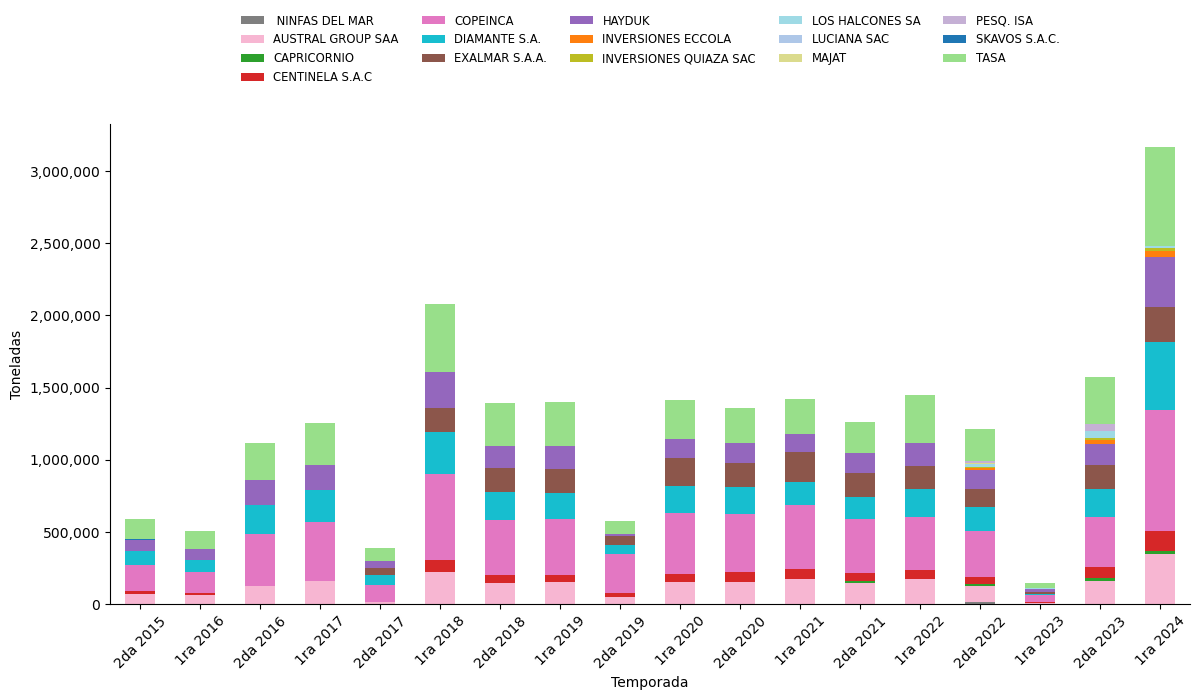

In [4]:
def ordenar_temporadas(etiqueta):
    """
    Convierte '1ra 2016' o '2da 2016' en un número ordenable.
    Ejemplo: '1ra 2016' -> 2016.0, '2da 2016' -> 2016.5
    """
    match = re.match(r"(1ra|2da)\s*(\d{4})", etiqueta)
    if match:
        temporada, anio = match.groups()
        return int(anio) + (0 if temporada == "1ra" else 0.5)
    return float('inf')



pivot_empresas = df_stats.pivot_table(
    index="temporada",
    columns="empresa_normalizada",
    values="volumen_empresa_tm",
    aggfunc="sum",
    fill_value=0,
)

orden = sorted(pivot_empresas.index, key=ordenar_temporadas)
pivot_empresas = pivot_empresas.loc[orden]


cmap = plt.colormaps["tab20"]
colors = cmap(np.linspace(0, 1, pivot_empresas.shape[1]))
np.random.shuffle(colors)


fig = plt.figure(figsize=(12, 6))
ax = plt.axes([0.05, 0.05, 0.9, 0.8])
pivot_empresas.plot(
    kind="bar",
    stacked=True,
    color=colors,
    ax=ax
)

ax.set_ylabel("Toneladas")
# ax.set_title("Participación de empresas por temporada", loc='left')
ax.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol=5, fontsize='small', frameon=False)
ax.set_xlabel("Temporada")
ax.set_xticks(range(len(orden)))
ax.set_xticklabels(orden, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

In [5]:
df_stats["anio"] = df_stats["temporada"].str.extract(r"(\d{4})").astype(int)
df_stats["tipo_temporada"] = df_stats["temporada"].str.extract(r"(1ra|2da)")

totales_por_temporada = (
    df_stats.groupby(["empresa_normalizada", "temporada", "tipo_temporada"])["volumen_empresa_tm"]
    .sum()
    .reset_index()
)

promedios_empresas = (
    totales_por_temporada.groupby(["empresa_normalizada", "tipo_temporada"])["volumen_empresa_tm"]
    .mean()
    .unstack()
    .rename(columns={"1ra": "promedio_1ra", "2da": "promedio_2da"})
)

promedios_empresas["promedio_anual"] = (
    totales_por_temporada.groupby("empresa_normalizada")["volumen_empresa_tm"].mean()
)

promedios_empresas = (
    promedios_empresas
    .round(0)
    .fillna(0)
    .sort_values("promedio_anual", ascending=False)
    .map(lambda x: f"{int(x):,}".replace(",", "."))
)


promedios_empresas.index.name = None
promedios_empresas.columns.name = None
promedios_empresas.head(10)

,promedio_1ra,promedio_2da,promedio_anual
COPEINCA,406.293,304.450,355.372
TASA,306.068,207.986,257.027
DIAMANTE S.A.,198.274,149.460,173.867
EXALMAR S.A.A.,164.842,127.470,146.156
HAYDUK,161.084,113.751,137.417
AUSTRAL GROUP SAA,160.342,108.808,134.575
CENTINELA S.A.C,54.025,48.761,51.722
LOS HALCONES SA,7.300,38.158,22.729
INVERSIONES ECCOLA,22.212,20.378,21.295
PESQ. ISA,433,31.722,21.293


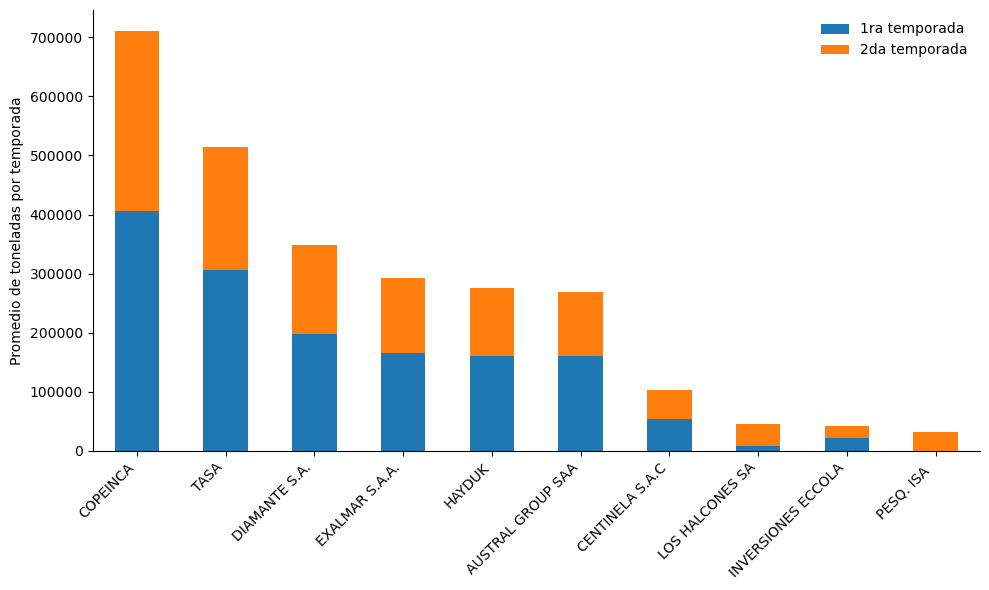

In [6]:

top_n = 10

df_plot = (
    promedios_empresas.copy()
    .replace({r"\.": "", "": None}, regex=True)
    .apply(pd.to_numeric, errors="coerce")
    .head(top_n)
)

fig, ax = plt.subplots(figsize=(10, 6))
df_plot[["promedio_1ra", "promedio_2da"]].plot(
    kind="bar",
    stacked=True,
    color=["#1f77b4", "#ff7f0e"],
    ax=ax
)

ax.set_ylabel("Promedio de toneladas por temporada")
ax.set_xlabel("")
ax.legend(["1ra temporada", "2da temporada"], frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Total temporadas: 18
Media de capturas por temporada: 1,238,829 tm
Temporadas filtradas (>= media): 11
Temporadas excluidas: ['1ra 2016', '1ra 2023', '2da 2015', '2da 2016', '2da 2017', '2da 2019', '2da 2022']

Cuotas estimadas por empresa (top 15):
                        Método 1 (Promedio %)  Método 2 (% Total)
AUSTRAL GROUP SAA                       11.22               11.14
CAPRICORNIO                              0.90                0.30
CENTINELA S.A.C                          3.93                4.01
COPEINCA                                28.23               27.95
DIAMANTE S.A.                           13.61               13.71
EXALMAR S.A.A.                          11.49               10.14
HAYDUK                                  10.90               10.91
INVERSIONES ECCOLA                       1.52                0.39
INVERSIONES QUIAZA SAC                   0.77                0.20
LOS HALCONES SA                          1.88                0.37
PESQ. ISA               

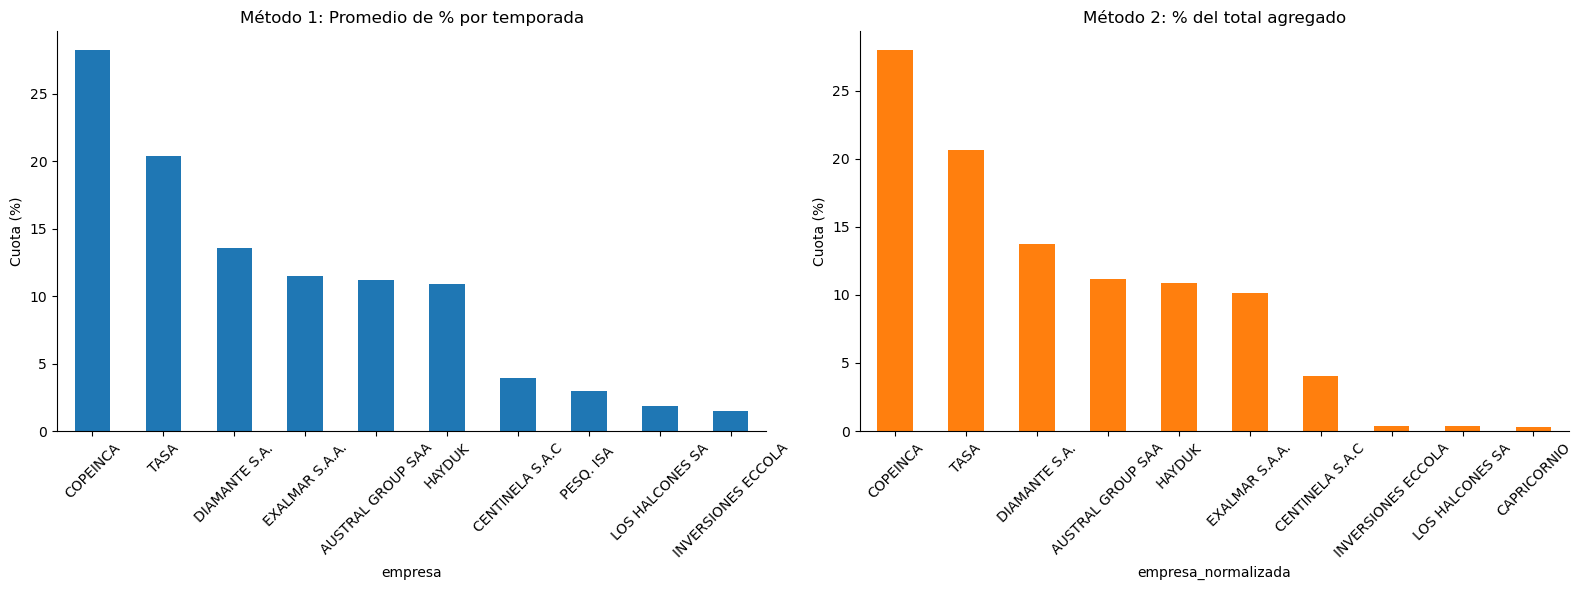

In [7]:
# Análisis de cuotas: filtra temporadas con capturas debajo de la media y calcula cuotas por ambos métodos

totales_temporada = df_stats.groupby("temporada")["volumen_empresa_tm"].sum()
media_total = totales_temporada.mean()
temporadas_filtradas = totales_temporada[totales_temporada >= media_total].index
df_filtrado = df_stats[df_stats["temporada"].isin(temporadas_filtradas)]

print(f"Total temporadas: {len(totales_temporada)}")
print(f"Media de capturas por temporada: {media_total:,.0f} tm")
print(f"Temporadas filtradas (>= media): {len(temporadas_filtradas)}")
print(f"Temporadas excluidas: {list(totales_temporada[totales_temporada < media_total].index)}")

metodo1_data = []
for temporada in temporadas_filtradas:
    temp_data = df_filtrado[df_filtrado["temporada"] == temporada]
    total_temp = temp_data["volumen_empresa_tm"].sum()
    for empresa in temp_data["empresa_normalizada"].unique():
        volumen_empresa = temp_data[temp_data["empresa_normalizada"] == empresa]["volumen_empresa_tm"].sum()
        porcentaje = (volumen_empresa / total_temp) * 100
        metodo1_data.append({"empresa": empresa, "temporada": temporada, "porcentaje": porcentaje})

metodo1_df = pd.DataFrame(metodo1_data)
cuotas_metodo1 = metodo1_df.groupby("empresa")["porcentaje"].mean().sort_values(ascending=False)

totales_empresa_filtrado = df_filtrado.groupby("empresa_normalizada")["volumen_empresa_tm"].sum()
total_general_filtrado = df_filtrado["volumen_empresa_tm"].sum()
cuotas_metodo2 = ((totales_empresa_filtrado / total_general_filtrado) * 100).sort_values(ascending=False)

resultados = pd.DataFrame({
    "Método 1 (Promedio %)": cuotas_metodo1,
    "Método 2 (% Total)": cuotas_metodo2
}).fillna(0).round(2)

print("\nCuotas estimadas por empresa (top 15):")
print(resultados.head(15))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

cuotas_metodo1.head(10).plot(kind="bar", color="#1f77b4", ax=ax1)
ax1.set_title("Método 1: Promedio de % por temporada")
ax1.set_ylabel("Cuota (%)")
ax1.tick_params(axis='x', rotation=45)

cuotas_metodo2.head(10).plot(kind="bar", color="#ff7f0e", ax=ax2)
ax2.set_title("Método 2: % del total agregado")
ax2.set_ylabel("Cuota (%)")
ax2.tick_params(axis='x', rotation=45)

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()